In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import HelperFunctions as hf

# Prepare Data

In [2]:
#load data
sales_df= hf.load_sales_train_validation_data()
calendar_df= hf.load_calendar_data()
prices_df= hf.load_sell_price_data()

In [3]:
#clean data
df = hf.rawToClean(sales_df, calendar_df, prices_df, days=1300, items=1000, dropNAPrices=True)

In [4]:
df.shape

(901753, 42)

In [5]:
#add rolling mean
df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=1) #Mean of previous week
df = hf.rollingMeanDemandFeature(df, windowSize=28, shift=1) #Mean of previous 28 days
#df = hf.rollingMeanDemandFeature(df, windowSize=365, shift=1) 

df = hf.rollingStdDemandFeature(df, windowSize=7, shift=1)
df = hf.rollingStdDemandFeature(df, windowSize=28, shift=1)
#df = hf.rollingStdDemandFeature(df, windowSize=365, shift=1)


df = hf.rollingMeanWeekday(df, weeks = 4, shift = 1) #mean of previous 3 weeks (for that particular weekday)
df = hf.rollingMeanWeekday(df, weeks = 8, shift = 1) #mean of previous 3 weeks (for that particular weekday)
#df = hf.rollingMeanWeekday(df, weeks = 52, shift = 1) #mean of previous 3 weeks (for that particular weekday)

#add lag
df = hf.lagFeature(df, var='sold', lag=1) #Amount sold day before
df = hf.lagFeature(df, var='sold', lag=7) #Amount sold a week before
df = hf.lagFeature(df, var='sold', lag=28) #Amount sold 28 days before
#df = hf.lagFeature(df, var='sold', lag=365) #Amount sold 1 year before

df.dropna(inplace=True) #Drop rows with NAs (as result of lagged features)

In [6]:
#product_ids = df.id.copy()
#df.drop(['id'], axis=1, inplace=True) #Drop the id column

In [7]:
df.head()

,id,d,sold,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price,...,WI,rolling_mean_7_1,rolling_mean_28_1,rolling_std_7_1,rolling_std_28_1,rolling_mean_4_1,rolling_mean_8_1,sold_lag_1,sold_lag_7,sold_lag_28
32002,HOUSEHOLD_2_134_CA_4_validation,33,0,5,3,2011,1,0,1,5.94,...,0,0.000000,0.071429,0.000000,0.262265,0.00,0.125,0,0,0
32008,FOODS_3_271_CA_1_validation,33,1,5,3,2011,1,0,1,4.98,...,0,0.142857,0.892857,0.377964,1.100144,0.00,0.625,0,0,0
32012,HOUSEHOLD_2_421_WI_3_validation,33,3,5,3,2011,1,0,1,4.67,...,1,2.000000,1.821429,1.732051,1.441542,1.75,1.875,0,2,0
32013,HOUSEHOLD_2_301_WI_2_validation,33,0,5,3,2011,1,0,1,2.27,...,1,1.000000,0.750000,1.000000,0.967050,0.75,0.625,0,1,0
32014,HOUSEHOLD_1_432_CA_2_validation,33,0,5,3,2011,1,0,1,3.86,...,0,0.285714,0.392857,0.487950,0.628890,0.50,0.500,1,0,0


In [8]:
df.columns

Index(['id', 'd', 'sold', 'wday', 'month', 'year', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'Cultural', 'National', 'Religious',
       'Sporting', 'NoEvent', 'Christmas', 'weekend', 'midweek', 'monfri',
       'FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2',
       'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS', 'HOBBIES', 'HOUSEHOLD', 'CA_1',
       'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3',
       'CA', 'TX', 'WI', 'rolling_mean_7_1', 'rolling_mean_28_1',
       'rolling_std_7_1', 'rolling_std_28_1', 'rolling_mean_4_1',
       'rolling_mean_8_1', 'sold_lag_1', 'sold_lag_7', 'sold_lag_28'],
      dtype='object')

In [9]:
#Standardise features
from sklearn.preprocessing import MinMaxScaler

cols_to_norm = ['d','wday','month','year','sell_price', 'rolling_mean_7_1', 'rolling_mean_28_1',
                'rolling_std_7_1', 'rolling_std_28_1', 'rolling_mean_4_1',
                'rolling_mean_8_1']

df[cols_to_norm] = MinMaxScaler().fit_transform(df[cols_to_norm])

In [10]:
df_test = df.loc[df["d"] > 1200/1300]
df_train = df.loc[df["d"] <= 1200/1300]

df_item = df.loc[df["id"] == "FOODS_2_360_TX_3_validation"]
df_item_test = df_item.loc[df_item["d"] > 1200/1300]

In [11]:
#Train set  (1200 days)
#df.drop(['id'], axis=1, inplace=True) #Drop the id column
X_train=df_train.drop(["id",'sold'],axis=1).values
y_train=df_train['sold'].values

In [12]:
#Test set  (1200 - 1300 days)
#df_test.drop(['id'], axis=1, inplace=True) #Drop the id column
X_test=df_test.drop(["id",'sold'],axis=1).values
y_test=df_test['sold'].values

In [13]:
#test set of item FOODS_2_360_TX_3_validation for last 100 days
X_item_test=df_item_test.drop(["id",'sold'],axis=1).values
y_item_test = df_item_test['sold'].values

In [14]:
print(len(set(df_test.d)))
print(len(set(df_item_test.d)))

98
98


In [15]:
def prepare(df):
    X = df.drop(["id","sold"], axis = 1).values
    y = df["sold"].values
    return(X, y)

In [16]:
def depMSE(col):
    df_dep = df[(df[col] == 1)]
    X_dep, y_dep = prepare(df_dep)
    preds_dep = model.predict(X_dep)
    return(mean_squared_error(preds_dep, y_dep))

# Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lm=LinearRegression()
lm.fit(X_train,y_train)


preds_train = lm.predict(X_train)
preds_test = lm.predict(X_test)
preds_item = lm.predict(X_item_test)

print(f"MSE on train set: {mean_squared_error(preds_train, y_train)}")
print(f"MSE on test set: {mean_squared_error(preds_test, y_test)}")
print(f"MSE on item prediction: {mean_squared_error(preds_item, y_item_test)}")

MSE on train set: 6.324875565692934
MSE on test set: 5.541172829061448
MSE on item prediction: 90.03323536563893


In [18]:
from sklearn.model_selection import cross_val_score

model=LinearRegression()

cv_score=cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

print(cv_score)
print("MSE CV:", -np.mean(cv_score))

[-6.32594071 -6.76305996 -6.11308115 -6.04113566 -6.50141052]
MSE CV: 6.348925599940289


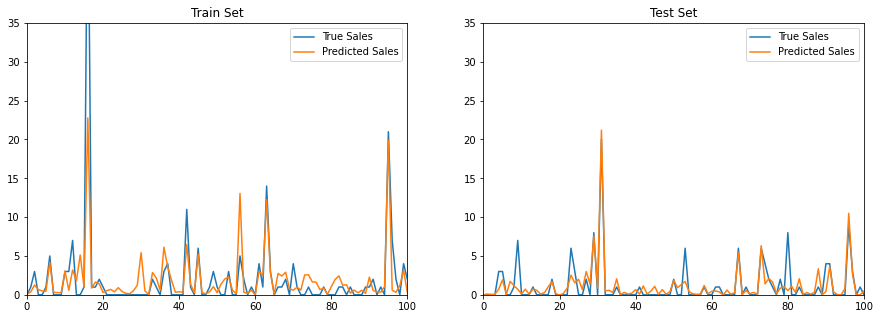

In [19]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(len(y_train)), y_train, label='True Sales')
ax[0].plot(np.arange(len(preds_train)), preds_train, label='Predicted Sales')
ax[0].set_title("Train Set")
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,35)
ax[0].legend()

ax[1].plot(np.arange(len(y_test)), y_test, label='True Sales')
ax[1].plot(np.arange(len(preds_test)), preds_test, label='Predicted Sales')
ax[1].set_title("Test Set")
ax[1].set_xlim(0,100)
ax[1].set_ylim(0,35)
ax[1].legend()

plt.show()

# LightGBM (LGBM)

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

pip install lightgbm

In [20]:
import lightgbm as lgb

model=lgb.LGBMRegressor(learning_rate=0.05,
                        boosting_type="gbdt",  
                        objective="regression",
                        metric="mse",
                        num_leaves=50,
                        max_depth=10,
                        n_estimators=100)

#X_train.astype(float)
#X_test.astype(float)
#y_train.astype(float)
#y_test.astype(float)

model.fit(X_train, y_train)

preds_train = model.predict(X_train)
preds_test = model.predict(X_test)
preds_item = model.predict(X_item_test)

print(f"MSE on train set: {mean_squared_error(preds_train, y_train)}")
print(f"MSE on test set: {mean_squared_error(preds_test, y_test)}")
print(f"MSE on item prediction: {mean_squared_error(preds_item, y_item_test)}")

MSE on train set: 5.002025859130816
MSE on test set: 5.110057125807843
MSE on item prediction: 83.56776375853846


In [21]:
#df_excel = pd.DataFrame(preds_item).T
#df_excel.to_excel(excel_writer = "./LGBM_item_predictions.xlsx")
#df_excel

In [22]:
#cross validation 
from sklearn.model_selection import cross_val_score

cv_score=cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

print(cv_score)
print("MSE CV:", -np.mean(cv_score))

[-5.96552586 -6.41279373 -5.66577841 -5.66139993 -5.87879757]
MSE CV: 5.916859101672749


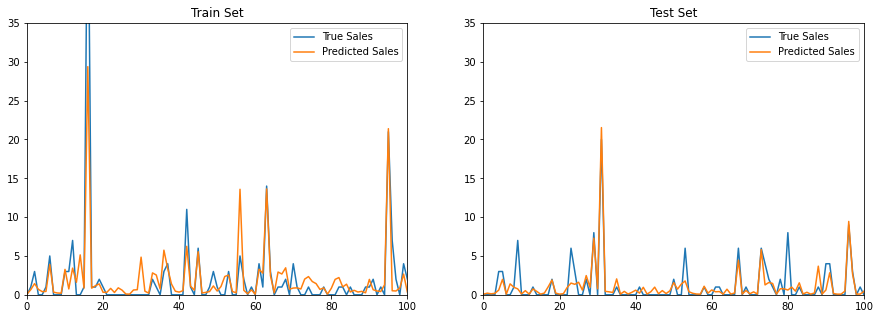

In [23]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(len(y_train)), y_train, label='True Sales')
ax[0].plot(np.arange(len(preds_train)), preds_train, label='Predicted Sales')
ax[0].set_title("Train Set")
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,35)
ax[0].legend()

ax[1].plot(np.arange(len(y_test)), y_test, label='True Sales')
ax[1].plot(np.arange(len(preds_test)), preds_test, label='Predicted Sales')
ax[1].set_title("Test Set")
ax[1].set_xlim(0,100)
ax[1].set_ylim(0,35)
ax[1].legend()

plt.show()

In [24]:
print(f" yo {depMSE('FOODS')}")

 yo 7.814258673556161


In [25]:
#MSE by Department
print("MSE by Department")
print(f"MSE FOOD: {depMSE('FOODS')}")
print(f"MSE HOUSEHOLD: {depMSE('HOUSEHOLD')}")
print(f"MSE HOBBIES: {depMSE('HOBBIES')}")

print()

#MSE by State
print("MSE by State")
print(f"MSE TX: {depMSE('TX')}")
print(f"MSE CA: {depMSE('CA')}")
print(f"MSE WI: {depMSE('WI')}")

MSE by Department
MSE FOOD: 7.814258673556161
MSE HOUSEHOLD: 1.7764689220737662
MSE HOBBIES: 4.899249810638473

MSE by State
MSE TX: 3.416843568209869
MSE CA: 5.097997209793718
MSE WI: 6.526329187685977


#  XGBoost

In [26]:
import xgboost as xgb

model = xgb.XGBRegressor(learning_rate = 0.05, 
                           max_depth = 10, 
                           alpha = 10, 
                           n_estimators = 100)

model.fit(X_train,y_train)

preds_train = model.predict(X_train)
preds_test = model.predict(X_test)
preds_item = model.predict(X_item_test)

print(f"MSE on train set: {mean_squared_error(preds_train, y_train)}")
print(f"MSE on test set: {mean_squared_error(preds_test, y_test)}")
print(f"MSE on item prediction: {mean_squared_error(preds_item, y_item_test)}")

MSE on train set: 3.4639559532435773
MSE on test set: 5.174109885321804
MSE on item prediction: 84.83668013716829


In [27]:
#df_excel = pd.DataFrame(preds_item).T
#df_excel.to_excel(excel_writer = "./XGBoost_item_predictions.xlsx")
#df_excel

In [28]:
#cross validation 
from sklearn.model_selection import cross_val_score

cv_score=cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

print(cv_score)
print("MSE CV:", -np.mean(cv_score))

[-6.03899819 -6.38142216 -5.88428949 -5.70083268 -6.59873839]
MSE CV: 6.120856180593163


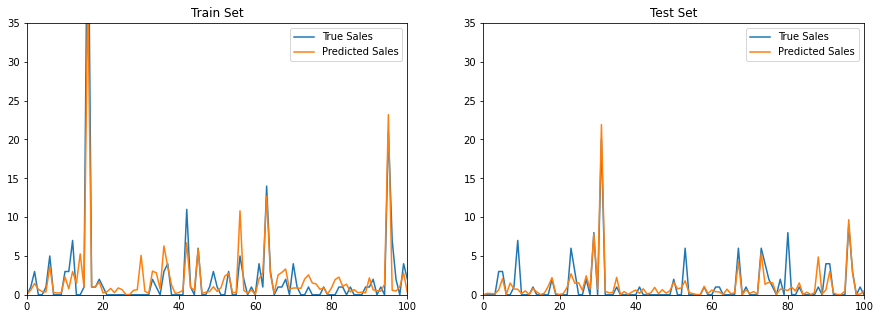

In [29]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(len(y_train)), y_train, label='True Sales')
ax[0].plot(np.arange(len(preds_train)), preds_train, label='Predicted Sales')
ax[0].set_title("Train Set")
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,35)
ax[0].legend()

ax[1].plot(np.arange(len(y_test)), y_test, label='True Sales')
ax[1].plot(np.arange(len(preds_test)), preds_test, label='Predicted Sales')
ax[1].set_title("Test Set")
ax[1].set_xlim(0,100)
ax[1].set_ylim(0,35)
ax[1].legend()

plt.show()

In [30]:
#MSE by Department
print("MSE by Department")
print(f"MSE FOOD: {depMSE('FOODS')}")
print(f"MSE HOUSEHOLD: {depMSE('HOUSEHOLD')}")
print(f"MSE HOBBIES: {depMSE('HOBBIES')}")

print()

#MSE by State
print("MSE by State")
print(f"MSE TX: {depMSE('TX')}")
print(f"MSE CA: {depMSE('CA')}")
print(f"MSE WI: {depMSE('WI')}")

MSE by Department
MSE FOOD: 5.331078122414794
MSE HOUSEHOLD: 1.607175969289762
MSE HOBBIES: 3.7398630386766007

MSE by State
MSE TX: 2.7403443051784384
MSE CA: 3.97978103589648
MSE WI: 4.112988908636833


# Hist Gradient Boosting Regressor

Its in sklearn and it says it is inspired from LightGBM so lets try it

In [31]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingRegressor

model=HistGradientBoostingRegressor()

model.fit(X_train, y_train)

preds_train = model.predict(X_train)
preds_test = model.predict(X_test)
preds_item = model.predict(X_item_test)

print(f"MSE on train set: {mean_squared_error(preds_train, y_train)}")
print(f"MSE on test set: {mean_squared_error(preds_test, y_test)}")
print(f"MSE on item prediction: {mean_squared_error(preds_item, y_item_test)}")

MSE on train set: 5.159860490420407
MSE on test set: 5.278785035683047
MSE on item prediction: 87.3468679045729


In [32]:
#cross validation 
from sklearn.model_selection import cross_val_score

cv_score=cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

print(cv_score)
print("MSE CV:", -np.mean(cv_score))

[-5.99950794 -6.43552354 -5.77451939 -5.76390883 -6.12707269]
MSE CV: 6.02010647881292


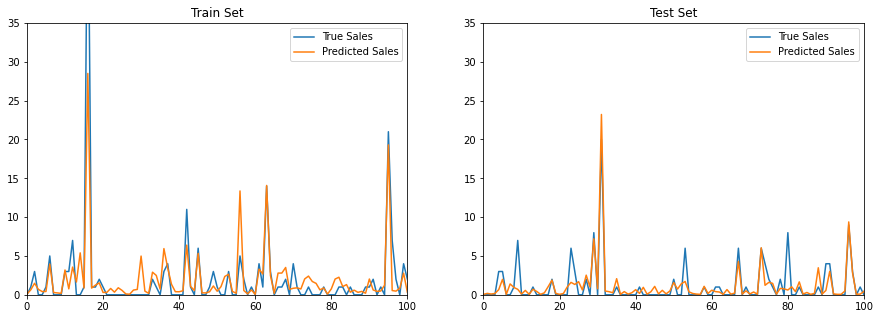

In [33]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(len(y_train)), y_train, label='True Sales')
ax[0].plot(np.arange(len(preds_train)), preds_train, label='Predicted Sales')
ax[0].set_title("Train Set")
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,35)
ax[0].legend()

ax[1].plot(np.arange(len(y_test)), y_test, label='True Sales')
ax[1].plot(np.arange(len(preds_test)), preds_test, label='Predicted Sales')
ax[1].set_title("Test Set")
ax[1].set_xlim(0,100)
ax[1].set_ylim(0,35)
ax[1].legend()

plt.show()